In [67]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

from torch.utils.data import DataLoader

from torchvision.transforms import functional as F 
from torchvision.utils import draw_segmentation_masks, make_grid

import torchdata.datapipes as dp 
from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterDataPipe

import pytorch_lightning as pl

cuda


In [2]:
#DATA = Path("/media/sambhav/30AC4696AC46568E/datasets/building-footprints-dataset")
DATA = Path("C:/Users/hp/Desktop/datasets/building-footprints-dataset")

TRAIN_DATA = DATA / "labelled" / "patches"
TRAIN_IMAGES = TRAIN_DATA / "images"
TRAIN_MASKS = TRAIN_DATA / "masks"
TRAIN_CATALOG = DATA / "labelled" / "metadata" / "patches.csv"

TEST_DATA = DATA / "labelled" / "scenes"
TEST_IMAGES = TEST_DATA / "images"
TEST_MASKS = TEST_DATA / "masks"

In [3]:
@functional_datapipe("load_example")
class ExampleLoader(IterDataPipe):
    def __init__(self, source_datapipe: IterDataPipe, image_prefix:Path , mask_prefix:Path):
        self.source_datapipe = source_datapipe
        self.image_prefix = image_prefix
        self.mask_prefix = mask_prefix

    def __iter__(self):
        for file_name, dataset_name in self.source_datapipe:
            image_path = self.image_prefix / file_name 
            mask_path = self.mask_prefix / file_name
            yield (image_path.as_posix(), 
                   mask_path.as_posix(), 
                   dataset_name)

In [4]:
@functional_datapipe("load_image")
class ImageLoader(IterDataPipe):
    def __init__(self, source_pipe: IterDataPipe):
        self.source_pipe = source_pipe
    
    def __iter__(self):
        for _, file_stream in self.source_pipe:
            image = iio.imread(file_stream, extension=".jpg")
            if image.ndim == 2:
                image = np.expand_dims(image, -1)
            image = torch.from_numpy(image).to(torch.float32)
            yield image

In [5]:
@functional_datapipe("preprocess_image")
class ImagePreprocessor(IterDataPipe):
    normalization_params = {
        #"dataset_name": ((rgb_means), (rgb_std_devs))
        "inria": ((0, 0, 0), (255., 255., 255.)),
        "city-osm": ((1, 1, 1), (.1, .1, .1)),
        "isprs": ((1, 1, 1), (.1, .1, .1)),
    }    

    def __init__(self, image_pipe: IterDataPipe, dataset_pipe: IterDataPipe):
        self.image_pipe = image_pipe
        self.dataset_pipe = dataset_pipe
    
    def __iter__(self):
        for image, dataset_name in zip(self.image_pipe, self.dataset_pipe):
            self.normalize(image, dataset_name)
            yield image
    
    def normalize(self, image, dataset_name):
        F.normalize(tensor = image.permute(2, 0, 1), 
                    mean = self.normalization_params[dataset_name][0], 
                    std = self.normalization_params[dataset_name][1],
                    inplace = True) # type: ignore

In [6]:
def pad_image(image: torch.Tensor):
    return F.pad(image.permute(2, 0, 1), 10).permute(1, 2, 0)

In [17]:
class BuildingFootprintsDataModule(pl.LightningDataModule):
    def __init__(self, root_dir: Path, bucket_name: str = "", batch_size: int = 32, random_seed: int = 42, num_workers:int = 1):
        super().__init__()
        self.batch_size = batch_size
        self.random_seed = random_seed
        self.num_workers = num_workers

        self.root_dir = root_dir 
        #If bucket name is not empty, source directory is a bucket
        if bucket_name:
            self.bucket_name = Path(bucket_name)
            self.setup_paths(bucket_name)
        else:
            self.bucket_name = None 
            self.setup_paths(self.root_dir)

        self.train_catalog = self.root_dir / "labelled" / "metadata" / "patches.csv"
        self.test_catalog = self.root_dir / "labelled" / "metadata" / "scenes.csv"
    
    def setup_paths(self, parent_dir):
        """Setup absolute paths w.r.t. argument location, which can be local or remote"""

        self.train_dir = parent_dir / "labelled" / "patches"
        self.train_image_prefix = self.train_dir / "images"
        self.train_mask_prefix = self.train_dir / "masks"

        self.test_dir = parent_dir / "labelled" / "scenes"
        self.test_image_prefix = self.test_dir / "images"
        self.test_mask_prefix = self.test_dir / "masks"
    
    def get_seg_dp(self, datapipe, image_prefix, mask_prefix):
        """Returns segmentation datapipe"""

        datapipe = datapipe.open_files()
        datapipe = datapipe.parse_csv(skip_lines = 1)
        
        datapipe = datapipe.load_example(image_prefix, mask_prefix).shuffle()
        image_pipe, mask_pipe, dataset_name_pipe = datapipe.unzip(3) 

        if self.bucket_name:
            image_pipe = image_pipe.load_files_by_s3()
            mask_pipe = mask_pipe.load_files_by_s3()

        else:
            image_pipe = image_pipe.open_files(mode = 'rb')
            mask_pipe = mask_pipe.open_files(mode = 'rb')

        image_pipe = image_pipe.load_image()
        mask_pipe = mask_pipe.load_image()

        return image_pipe, mask_pipe, dataset_name_pipe

    def prepare_train_datapipe(self, datapipe):
        image_pipe, mask_pipe, dataset_name_pipe = self.get_seg_dp(datapipe, 
                                                                   self.train_image_prefix,
                                                                   self.train_mask_prefix) 
                            
        #Apply Training Specific Transformations

        mask_pipe = mask_pipe.map(pad_image)
        image_pipe = image_pipe.preprocess_image(dataset_name_pipe)
        image_pipe = image_pipe.map(pad_image)
        return image_pipe.zip(mask_pipe)
    
    def prepare_test_datapipe(self, datapipe):
        image_pipe, mask_pipe, dataset_name_pipe = self.get_seg_dp(datapipe, 
                                                                   self.test_image_prefix,
                                                                   self.test_mask_prefix) 
        #Apply Testing Specific Transformations
        mask_pipe = mask_pipe.map(pad_image)
        image_pipe = image_pipe.preprocess_image(dataset_name_pipe)
        image_pipe = image_pipe.map(pad_image)
        return image_pipe.zip(mask_pipe)

    def prepare_data(self) -> None:
        if self.bucket_name:
            #storage = ContaboStorage(self.bucket_name)
            #storage.download_train_catalog(self.train_catalog)
            #storage.download_test_catalog(self.test_catalog)
            pass

    def setup(self, stage: str): 
        if stage == "fit":
            self.train_df = pd.read_csv(self.train_catalog, index_col=0)
            train_size = len(self.train_df)

            pipe = self.prepare_train_datapipe(
                datapipe = dp.iter.IterableWrapper([self.train_catalog.as_posix()])
            )
            self.train_dp, self.val_dp = pipe.random_split(total_length = len(self.train_df), 
                                                           weights = {"train": 0.8 * train_size, "val": 0.2 * train_size},
                                                           seed = self.random_seed)

        if stage == "test":
            self.test_df = pd.read_csv(self.test_catalog, index_col=0)
            self.test_dp = self.prepare_test_datapipe(
                datapipe = dp.iter.IterableWrapper([self.test_catalog.as_posix()])
            )
    
    def train_dataloader(self):
        return DataLoader(dataset = self.train_dp, batch_size = self.batch_size, shuffle = True) 
                          #num_workers = self.num_workers)#, prefetch_factor = self.prefetch_factor)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dp, batch_size = self.batch_size, shuffle = True) 
                          #num_workers = self.num_workers, prefetch_factor = self.prefetch_factor)

    def test_dataloader(self):
        return DataLoader(dataset = self.test_dp, batch_size = self.batch_size, shuffle = True) 
                          #num_workers = self.num_workers)#, prefetch_factor = self.prefetch_factor)


In [18]:
dm = BuildingFootprintsDataModule(DATA)
dm.prepare_data()

In [31]:
images, masks = next(iter(dm.val_dataloader()))
print(images.shape, masks.shape)

c:\Users\hp\miniconda3\envs\ml\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [76]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

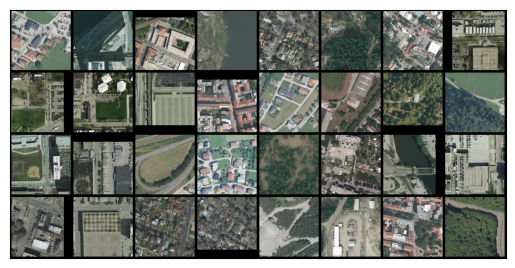

In [80]:
grid = make_grid(images.permute(0, 3, 1, 2))
show(grid)